In [1]:
from data import DatabaseManager

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

2024-01-16 03:05:43.452159: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 03:05:43.490888: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 03:05:43.491386: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 03:05:44.161278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Instanciamos el manejador de la base de datos
manager = DatabaseManager()

In [3]:
# Extraemos los datos de entrenamiento - partidas standar, rated a ritmo blitz 
df = manager.extract_data_for_training()
df.head()

,players_white_rating,players_black_rating,opening_eco,opening_ply,clock_initial,clock_increment,duracion_partida,numero_total_movimientos,resultado
0,1747.0,1746.0,D04,5.0,180.0,2.0,124.490,26,-1.0
1,1739.0,1681.0,C25,4.0,180.0,2.0,226.774,43,1.0
2,1763.0,1747.0,D00,3.0,300.0,3.0,262.231,25,1.0
3,1735.0,1738.0,B01,4.0,300.0,3.0,356.927,52,-1.0
4,1729.0,1730.0,C25,4.0,180.0,0.0,366.086,67,1.0


In [4]:
def preprocess_df(df):
    df = clean_data(df)
    df = encode_categorical(df, ['opening_eco'])
    df = normalize_numeric(df, ['duracion_partida', 'numero_total_movimientos'])
    df['players_white_rating'] = df['players_white_rating'] / 3500
    df['players_black_rating'] = df['players_black_rating'] / 3500
    return df

def clean_data(df):
    df.columns = df.columns.astype(str)
    df.dropna(inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

def normalize_numeric(df, numeric_cols):
    try:
        scaler = MinMaxScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    except ValueError as e:
        print(f"Error en la normalización: {e}")
    return df

def encode_categorical(df, categorical_cols):
    for col in categorical_cols:
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])
    return df

In [5]:
features_df = preprocess_df(df)
features_df

,players_white_rating,players_black_rating,opening_eco,opening_ply,clock_initial,clock_increment,duracion_partida,numero_total_movimientos,resultado
0,0.499143,0.498857,134,5.0,180.0,2.0,0.124297,0.119617,-1.0
1,0.496857,0.480286,92,4.0,180.0,2.0,0.228470,0.200957,1.0
2,0.503714,0.499143,130,3.0,300.0,3.0,0.264581,0.114833,1.0
3,0.495714,0.496571,46,4.0,300.0,3.0,0.361026,0.244019,-1.0
4,0.494000,0.494286,92,4.0,180.0,0.0,0.370354,0.315789,1.0
...,...,...,...,...,...,...,...,...,...
3287,0.434571,0.432857,130,3.0,300.0,0.0,0.603843,0.358852,-1.0
3288,0.412571,0.410857,136,3.0,300.0,0.0,0.364567,0.277512,1.0
3289,0.435429,0.444857,28,1.0,300.0,0.0,0.541870,0.492823,-1.0
3290,0.469143,0.469429,100,6.0,300.0,0.0,0.598397,0.277512,1.0


In [6]:
# Separar características y etiquetas; división en entrenamiento, validación y prueba
X = features_df.drop('resultado', axis=1)
y = features_df['resultado']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [8]:
X_train

,players_white_rating,players_black_rating,opening_eco,opening_ply,clock_initial,clock_increment,duracion_partida,numero_total_movimientos
0,0.520286,0.505714,46,2.0,300.0,0.0,0.402249,0.234450
1,0.492857,0.499143,61,3.0,180.0,0.0,0.250735,0.263158
2,0.496286,0.476857,111,7.0,180.0,2.0,0.294362,0.354067
3,0.499143,0.487429,83,6.0,180.0,0.0,0.358934,0.320574
4,0.533429,0.532286,92,4.0,180.0,0.0,0.305124,0.320574
...,...,...,...,...,...,...,...,...
1882,0.479714,0.488000,107,4.0,180.0,0.0,0.144411,0.272727
1883,0.497714,0.546000,0,1.0,180.0,0.0,0.141458,0.224880
1884,0.572000,0.516286,46,2.0,180.0,0.0,0.186336,0.497608
1885,0.491143,0.495429,81,3.0,180.0,0.0,0.332387,0.354067


In [9]:
y_train

0      -1.0
1      -1.0
2       1.0
3      -1.0
4      -1.0
       ... 
1882   -1.0
1883   -1.0
1884    1.0
1885   -1.0
1886   -1.0
Name: resultado, Length: 1887, dtype: float64

In [10]:
# Codificación one-hot de las etiquetas
y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

In [11]:
# Definir el modelo
model = Sequential()
model.add(Dense(6, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(y_train_onehot.shape[1], activation='softmax'))  # Número de clases

2024-01-16 03:05:45.583139: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [12]:
# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(X_train, y_train_onehot, validation_data=(X_val, y_val_onehot), epochs=20, batch_size=32)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test_onehot)
print(f"Test Accuracy: {accuracy * 100}%")

Epoch 1/20
59/59 [==============================] - 1s 3ms/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/20
59/59 [==============================] - 0s 1ms/step - loss: 8.5245e-04 - accuracy: 0.9995 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
59/59 [==============================] - 0s 1ms/step - loss: 5.0692e-04 - accuracy: 0.9995 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
59/59 [==============================] - 0s 1ms/step - loss: 2.9417e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/20
59/59 [==============================] - 0s 1ms/step - loss: 1.7262e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
59/59 [==============================] - 0s 1ms/step - loss: 1.1433e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
59/59 [==============================] - 0s 1ms/step - loss: 8.1058e-05 - accuracy: 1.0000 - val_loss: 0.

In [13]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.show()

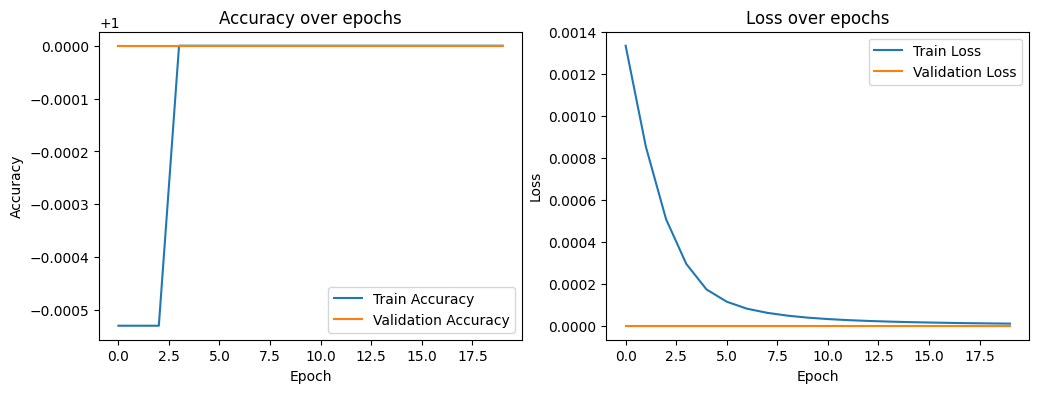

In [14]:
plot_training_history(history)